In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle/StrokePrediction"

In [4]:
%cd /content/gdrive/My Drive/kaggle/StrokePrediction

/content/gdrive/My Drive/kaggle/StrokePrediction


In [5]:
!ls

feature_names.pickle		    model.pickle	  X_test.pickle
healthcare-dataset-stroke-data.csv  model_stacked.pickle  y_re.pickle
kaggle.json			    X_re.pickle		  y_test.pickle


#Downloading the data (Only first execution)

First we download the dataset from kaggle

In [ ]:
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset

  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 9.25MB/s]


Let's unzip the files

In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  stroke-prediction-dataset.zip
  inflating: healthcare-dataset-stroke-data.csv  


What files are present in the current directory?

In [ ]:
!ls

healthcare-dataset-stroke-data.csv  kaggle.json


#Data Extraction 

Importing libraries

In [6]:
import pandas as pd
import numpy as np

Importing the dataset

In [7]:
dataset=pd.read_csv("healthcare-dataset-stroke-data.csv")
dataset

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Number of positive cases in the dataset

In [8]:
dataset[dataset["stroke"]==1].shape[0]

249

In [9]:
#percentage of positive cases
dataset[dataset["stroke"]==1].shape[0]/dataset.shape[0] *100

4.87279843444227

Number of negative cases in the dataset

In [10]:
dataset[dataset["stroke"]==0].shape[0]

4861

In [11]:
#percentage of negative cases
dataset[dataset["stroke"]==0].shape[0]/dataset.shape[0] *100

95.12720156555773

Let's see some info about the data

In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


All columns in the dataset have **non -null** values except the bmi column . This means that all the other information is available for each patient except the bmi.

#EDA
Now that we have extracted the dataset from Kaggle , we can begin our Exploratory Data Analysis. EDA is an extremely important  step since it helps us in understanding what our data means and what it represents .

---

Importing essentials

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

Let's explore the data. We will start by plotting the distribution of different parameters.

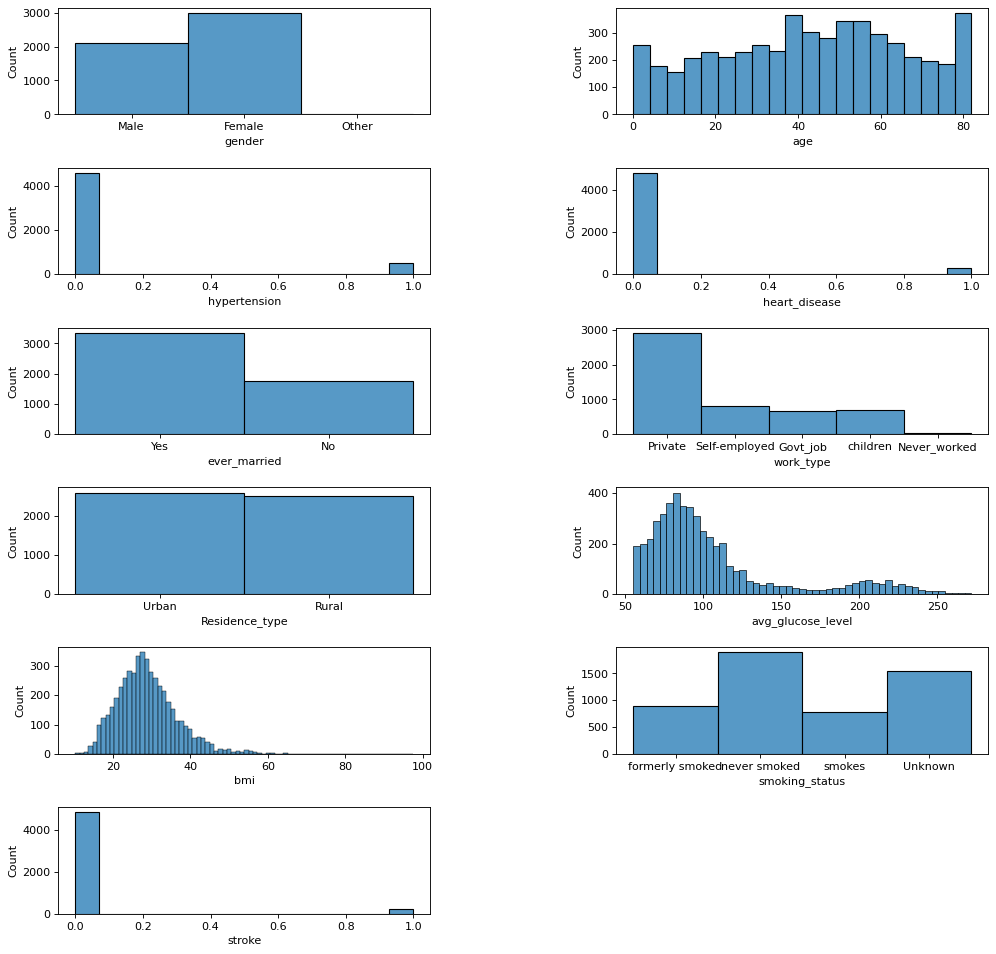

In [14]:
fig = plt.figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(1,12):
  ax=fig.add_subplot(6,2,i)
  sns.histplot(dataset,x=dataset.columns[i],ax=ax)
plt.show()

**OKAY!!!**  There are a lot of interesting questions that can be asked by looking at the histograms above.The next important thing to do is to make a correlation heatmap between these parameters .</br>
A correlation heatmap allows us to make connections between parameters. It helps us in finding out how these different parameters vary with respect to the the value of other parameters.If two variables are **positively correlated** , the increase in the value of one variable results in the increase in the value of the correlated variable.The opposite happens in case of **negatively correlated** variables.


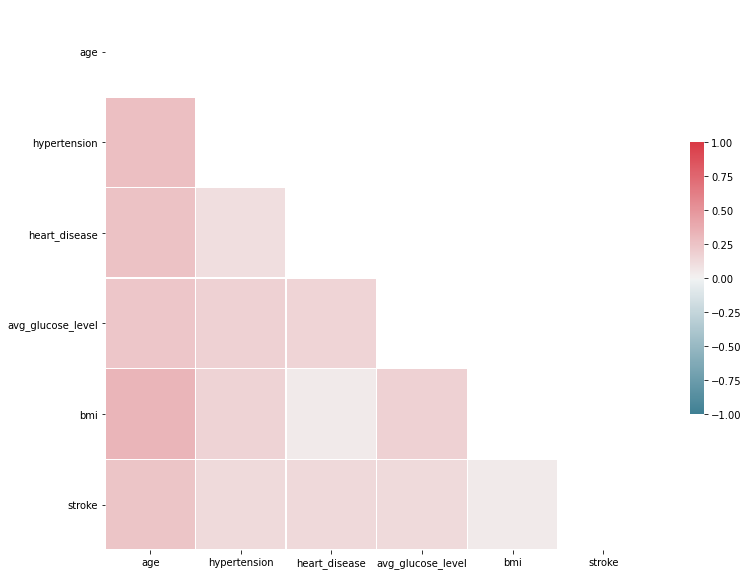

In [15]:
correlation=dataset.iloc[:,1:].corr()
mask=np.triu(np.ones_like(correlation,dtype=np.bool))
f,ax=plt.subplots(figsize=(15,10))
cmap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(correlation,mask=mask,cmap=cmap,vmax=1,vmin=-1,center=0,square=True,linewidths=.5,cbar_kws={'shrink':.5})

In [16]:
dataset.iloc[:,1:].corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.276398,0.263796,0.238171,0.333398,0.245257
hypertension,0.276398,1.000000,0.108306,0.174474,0.167811,0.127904
heart_disease,0.263796,0.108306,1.000000,0.161857,0.041357,0.134914
avg_glucose_level,0.238171,0.174474,0.161857,1.000000,0.175502,0.131945
bmi,0.333398,0.167811,0.041357,0.175502,1.000000,0.042374
stroke,0.245257,0.127904,0.134914,0.131945,0.042374,1.000000


The correlations between the variables are not strong but they might be enough to predict whether a person will get a stroke or not .

---

Now let's try to answer some interesting questions:


*   Does living in urban areas have any effect on your health ? Are people in rural areas less prone to strokes? 
* How does BMI relate the likelihood of getting a stroke? 
* How does work type affect the likelihood of getting a stroke?
* Do married people have a higher chance of suffering from a stroke?
* What about smoking ? Can it cause a stroke?



###**1.Does living in urban areas have any effect on your health ? Are people in rural areas less prone to strokes?** </br>


Let's look at the distribution of Residence_type for the people who suffered from a stroke

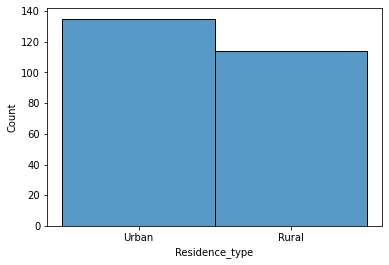

In [17]:
stroked=dataset[dataset["stroke"]==1]
unstroked=dataset[dataset["stroke"]==0]
sns.histplot(stroked,x="Residence_type")

Do the percentages of stroke cases from both the populations differ significantly?

In [18]:
urban= (stroked[stroked["Residence_type"]=="Urban"].shape[0]/dataset[dataset["Residence_type"]=="Urban"].shape[0]) *100
rural= (stroked[stroked["Residence_type"]=="Rural"].shape[0]/dataset[dataset["Residence_type"]=="Rural"].shape[0]) *100
print("Percentage of urban residents who got stroke: {0:.2f} % ".format(urban))
print("Percentage of rural residents who got stroke: {0:.2f} % ".format(rural))
del urban
del rural

Percentage of urban residents who got stroke: 5.20 % 
Percentage of rural residents who got stroke: 4.53 % 


The percentage of people who suffered from stroke and lived in urban areas is not significantly different when compared to the people who lived in rural areas and suffered from a stroke . So we cannot conclude that living in urban areas might make it more likely for people to suffer from a stroke

###**2.How does BMI relate to the likelihood of having a stroke?** </br>
We can start by seeing if there are any major differences in the distribution of bmi between the people who suffered from a stroke and the people who do not suffer from a stroke.

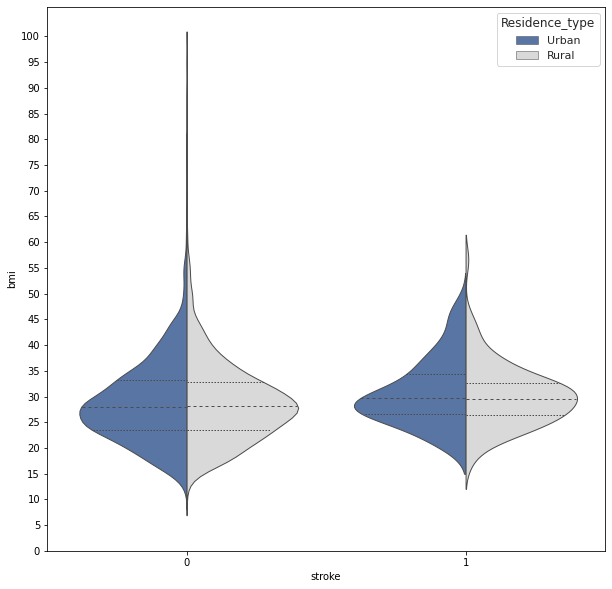

In [19]:
#this is a violin plot for bmi vs stroke with hue="Residence_type"
f,ax=plt.subplots(figsize=(10,10))
sns.set_theme(style="whitegrid")
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=dataset, x="stroke", y="bmi", hue="Residence_type",
               split=True, inner="quart", linewidth=1,
               palette={"Urban": "b", "Rural": ".85"})
plt.yticks(np.arange(0,105,5))
plt.show()

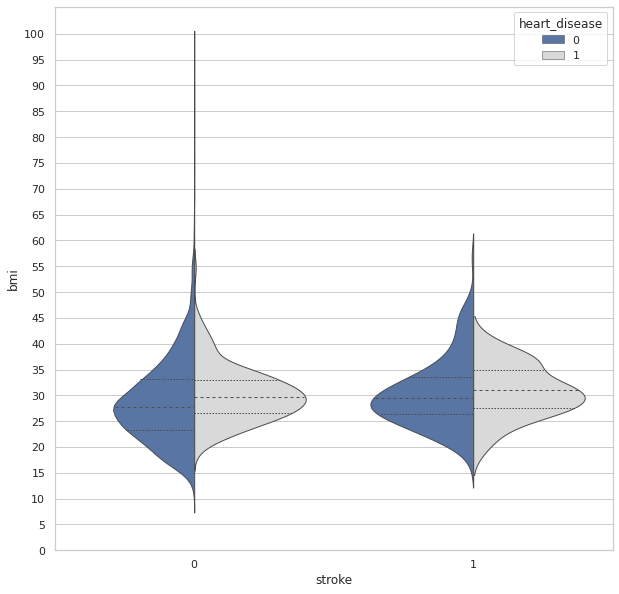

In [20]:
#this is a violin plot for bmi vs stroke with hue="heart_disease"
f,ax=plt.subplots(figsize=(10,10))
sns.set_theme(style="whitegrid")
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=dataset, x="stroke", y="bmi", hue="heart_disease",
               split=True, inner="quart", linewidth=1,
               palette={0: "b", 1: ".85"})
plt.yticks(np.arange(0,105,5))
plt.show()

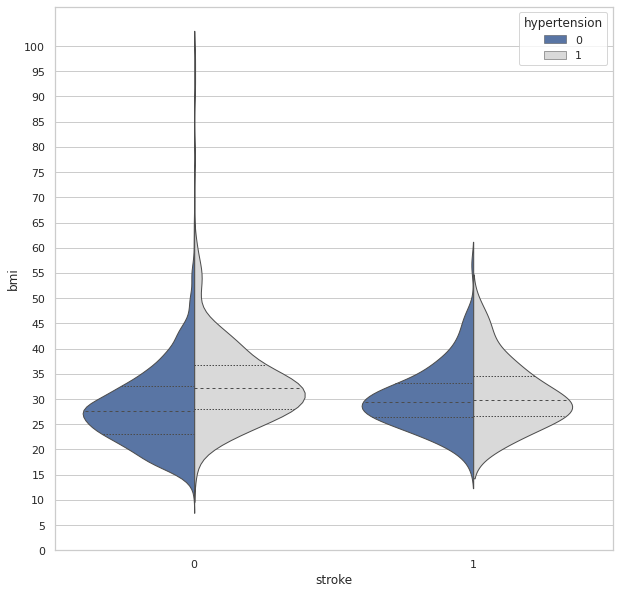

In [21]:
#this is a violin plot for bmi vs stroke with hue="hypertension"
f,ax=plt.subplots(figsize=(10,10))
sns.set_theme(style="whitegrid")
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=dataset, x="stroke", y="bmi", hue="hypertension",
               split=True, inner="quart", linewidth=1,
               palette={0: "b", 1: ".85"})
plt.yticks(np.arange(0,105,5))
plt.show()

We can also see dig into how age and bmi are distributed for the two categories : **stroke , no stroke**

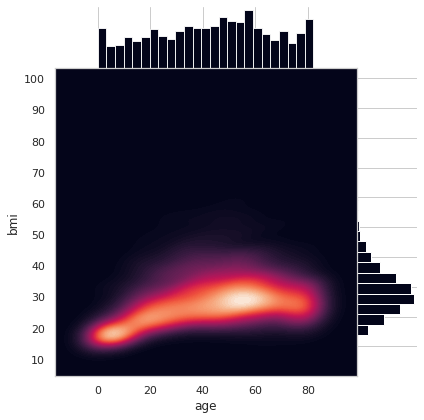

In [22]:
#this is the smooth kernel density plot for the complete dataset
g = sns.JointGrid(data=dataset, x="age", y="bmi", space=0)
g.plot_joint(sns.kdeplot,
             fill=True, 
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)
plt.yticks(np.arange(0,105,10))
plt.show()

Smooth KDE plot for the people who did not have a stroke

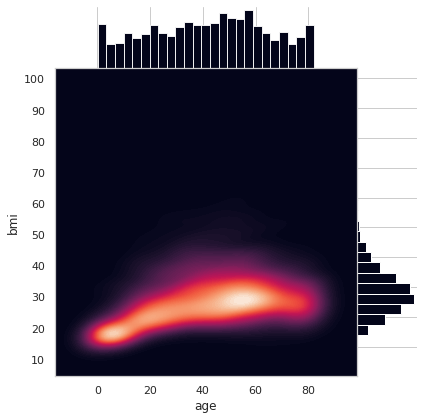

In [23]:
g = sns.JointGrid(data=unstroked, x="age", y="bmi", space=0)
g.plot_joint(sns.kdeplot,
             fill=True, 
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)
plt.yticks(np.arange(0,105,10))
plt.show()

Smooth KDE plot for the people who had a stroke

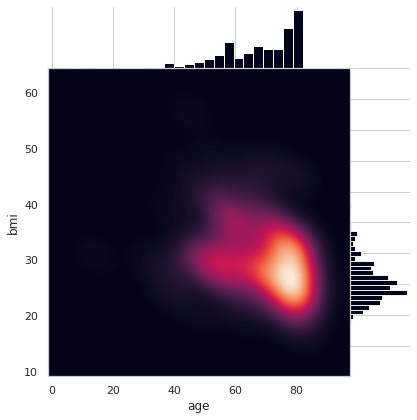

In [24]:
g = sns.JointGrid(data=stroked, x="age", y="bmi", space=0)
g.plot_joint(sns.kdeplot,
             fill=True, 
             thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)
plt.yticks(np.arange(0,105,10))
plt.show()

###**3.How does work type affect the likelihood of getting a stroke?**
A reasonable question to ask: Is your work so stressful that it causes a stroke?</br>
We shall try to answer that question using our dataset.First of all , let's see what is the distribution of work_type for the people who suffered from a stroke. 

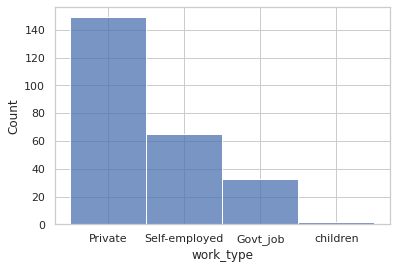

In [25]:
stroked=dataset[dataset["stroke"]==1]
unstroked=dataset[dataset["stroke"]==0]
sns.histplot(stroked,x="work_type")

In [26]:
priv= (stroked[stroked["work_type"]=="Private"].shape[0]/dataset[dataset["work_type"]=="Private"].shape[0]) *100
self_emp= (stroked[stroked["work_type"]=="Self-employed"].shape[0]/dataset[dataset["work_type"]=="Self-employed"].shape[0]) *100
govt= (stroked[stroked["work_type"]=="Govt_job"].shape[0]/dataset[dataset["work_type"]=="Govt_job"].shape[0]) *100
print("Percentage of people having private jobs who got stroke: {0:.2f} % ".format(priv))
print("Percentage of self-employed people who got stroke: {0:.2f} % ".format(self_emp))
print("Percentage of government employees who got stroke: {0:.2f} % ".format(govt))
del priv
del self_emp
del govt

Percentage of people having private jobs who got stroke: 5.09 % 
Percentage of self-employed people who got stroke: 7.94 % 
Percentage of government employees who got stroke: 5.02 % 


This is interesting . There is a higher percentage of self-employed people suffering from a stroke than people who work in private jobs or government jobs. Since the dataset has very less instances , we cannot conclude anything but this can be a potential direction for further investigation.


###**4.Do married people have a higher chance of suffering from a stroke?**

First let's see the distribution of the people who suffered from a stroke

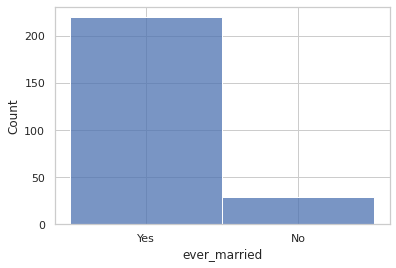

In [27]:
sns.histplot(stroked,x="ever_married")

Most of the people who sufffered from a stroke have been married at least once .This is due to the fact that most people who suffered from a stroke are middle aged (40-60) or old (60-80).

To answer the question posed above we are going to use conditional probability. In particular we are going to compare two probabilities :

*   P(Stroke|married)
*   P(Stroke|not married)

To calculate the above probabilties we are going to use the formula:

**P(A|B)= P(A and B) / P(B)**

---


**P(Stroke|married)**

In [28]:
df_prob=dataset[["ever_married","stroke"]]
df_prob["count"]=1
pd.pivot_table(
    df_prob,
    values="count",
    index=["ever_married"],
    columns=["stroke"],
    aggfunc=np.size,
    fill_value=0
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


stroke,0,1
ever_married,,
No,1728,29
Yes,3133,220


In [29]:
220/(1728+29+3133+220)

0.043052837573385516

**P(Stroke|not married)**

In [30]:
29/(1728+29+3133+220)

0.005675146771037182

Although we can see from above that married people have a higher probability of stroke , this could be due to the fact that there is bias in the dataset.Tp be precise , there aren't enough data points of unmarried people who suffered from a stroke. The dataset does not contain enough samples to justify the effect of marriage on the likelihood of having a stroke. So we cannot conclude anything.

###**5.What about smoking ? Can it cause a stroke?**

As always let's see the distribution of smoking_status among the people who had a stroke

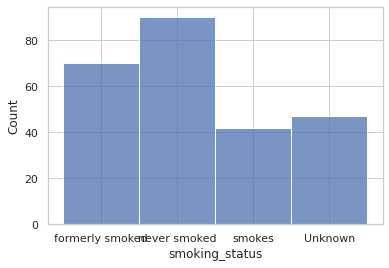

In [31]:
sns.histplot(stroked,x="smoking_status")

Here , we are going to use conditional probability as we have done in the last question.In this question we will be comparing the following probabilities:


*   P(Stroke|has smoked)
*   P(Stroke|never smoked)

**has smoked** will contain the instances from the following classes: formerly smoked , smokes </br>

**never smoked** will contain the instances from the following classes:
never_smoked and unknown 


In [32]:
def smoked(value):
  if value =="formerly smoked" or value =="smokes":
    return 1
  else:
    return 0

In [33]:
df_smoke=dataset
df_smoke["smoked"]=list(map(smoked,dataset["smoking_status"]))
df_smoke=df_smoke[["smoked","stroke"]]
df_smoke["count"]=1
pd.pivot_table(
    df_smoke,
    values="count",
    index=["smoked"],
    columns=["stroke"],
    aggfunc=np.size,
    fill_value=0
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


stroke,0,1
smoked,,
0,3299,137
1,1562,112


**P(Stroke|has smoked)**

In [34]:
112/(3299+137+1562+112)

0.021917808219178082

**P(Stroke|never smoked)**

In [35]:
137/(3299+137+1562+112)

0.02681017612524462

From above , we can see that the probabilities for both scenarios are almost equal . According to the probabilities , smoking does not increase the likelihood of having a stroke but more data is needed to substantiate this claim. In the above dataset , there are many people for whom the smoking_status is unknown . If the smoking_status for these people is known then  we can make better conclusions.

###**Some more interesting plots**

Scatter Plot of Avg. Glucose Level Vs Age 

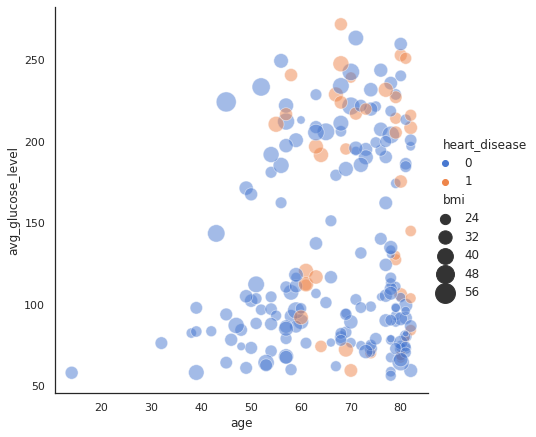

In [36]:
sns.set_theme(style="white")
sns.relplot(x="age", y="avg_glucose_level", hue="heart_disease", size="bmi",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=stroked)

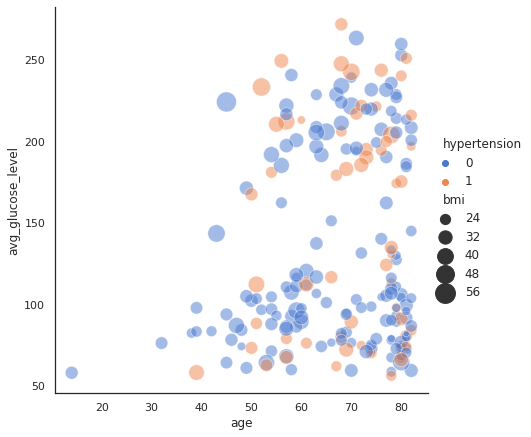

In [37]:
sns.set_theme(style="white")
sns.relplot(x="age", y="avg_glucose_level", hue="hypertension", size="bmi",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=stroked)

For further exploration,we can divide the patients according to the following sub-groups :
- Infancy and Toddlerhood. (0-2)
- Early Childhood.(3-6)
- Middle Childhood.(7-11)
- Adolescence.(12-18)
- Early Adulthood.(19-40)
- Middle Adulthood.(41-65)
- Late Adulthood.(66 and above)

These age groups are the different stages of human development and it may help us understand our patients better. Also , this can lead to more interesting questions and discoveries.

[The stages of human development](https://courses.lumenlearning.com/wmopen-lifespandevelopment/chapter/human-development/)

---
But let's end the exploration here and move on to the next stage : Data pre-processing and model training